## Download dataset

MovieLens dataset is available at https://grouplens.org/datasets/movielens/:
- We will use the ratings and movies from ml-1m

\
IMDB dataset is available at https://datasets.imdbws.com/ \
It is interesting to merge idmb genres for a movie to complement the MovieLens dataset, but some movies have the same title and year so we cannot identify them uniquely. We will ignore this issue for now.
- We will use:
    - title.basics.tsv.gz, needed to merge with MovieLens dataset
    - (might use) title.ratings.tsv.gz, might be interesting to compare MovieLens ratings with IMDB ratings average, or recommend movies that are not in MovieLens dataset

- We will not use:
    - name.basics.tsv.gz, users could be die hard fans of a particular actor or director, crew and principals are more interesting than this file, but we will keep it for possible later use (we might want to know which name is associated with which id)
    - title.akas.tsv.gz, we don't actually need the title in different languages to merge with MovieLens dataset, title in title.basics.tsv.gz was enough for most cases
    - title.crew.tsv.gz, to associate a movie with its director
    - title.episode.tsv.gz, our task is to recommend movies, not TV shows
    - (might use) title.principals.tsv.gz, to associate a movie with its actors (we will only use the director in crew for now)

In [ ]:
%%bash
curl -O https://files.grouplens.org/datasets/movielens/ml-1m.zip && unzip ml-1m.zip;
for i in 'name.basics.tsv.gz' 'title.basics.tsv.gz' 'title.ratings.tsv.gz';
do curl -O https://datasets.imdbws.com/$i ; done;
gunzip *.gz;
rm *.zip;

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed


Error while terminating subprocess (pid=228035): 


100 5778k  100 5778k    0     0   835k      0  0:00:06  0:00:06 --:--:-- 1128k
unzip:  cannot find or open ml-1m.zip, ml-1m.zip.zip or ml-1m.zip.ZIP.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  256M  100  256M    0     0  17.4M      0  0:00:14  0:00:14 --:--:-- 25.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  404M  100  404M    0     0  35.2M      0  0:00:11  0:00:11 --:--:-- 32.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  182M  100  182M    0     0  11.2M      0  0:00:16  0:00:16 --:--:-- 24.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Sp

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2024-07-07 21:17:17.805659: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 21:17:17.808092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-07 21:17:17.808101: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load dataset

Let's load the datasets and take a look at them

### MovieLens dataset

In [2]:
# to limit the number of rows read, set nrows to None to read all rows
nrows = None

In [3]:
ml_df = pd.read_csv('ml-1m/movies.dat', sep='::', names=['movie_id', 'title', 'genres'], engine='python', nrows=nrows)
ml_df.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


genres are separated by '|', we will split and create a column for each genre

In [4]:
ml_ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python', nrows=nrows)
ml_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
ml_ratings.rating.value_counts().index.sort_values()

Int64Index([1, 2, 3, 4, 5], dtype='int64')

### IMDB dataset

#### title.basics.tsv.gz

In [6]:
basics_df = pd.read_csv('title.basics.tsv', sep='\t', na_values='\\N', nrows=nrows)
basics_df

/home/aweng/anaconda3/envs/recommender-system-lectures/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3308: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,5.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10911799,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0.0,2009.0,NaN,NaN,"Action,Drama,Family"
10911800,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0.0,2010.0,NaN,NaN,"Action,Drama,Family"
10911801,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0.0,2010.0,NaN,NaN,"Action,Drama,Family"
10911802,tt9916856,short,The Wind,The Wind,0.0,2015.0,NaN,27,Short


#### title.rating.tsv.gz

In [7]:
ratings_df = pd.read_csv('title.ratings.tsv', sep='\t', na_values='\\N', nrows=nrows)
ratings_df

,tconst,averageRating,numVotes
0,tt0000001,5.7,2063
1,tt0000002,5.6,279
2,tt0000003,6.5,2030
3,tt0000004,5.4,180
4,tt0000005,6.2,2796
...,...,...,...
1453786,tt9916730,7.0,12
1453787,tt9916766,7.1,23
1453788,tt9916778,7.2,37
1453789,tt9916840,7.2,10


## Data preprocessing

Goal: create user-item matrix
- associate imdb titleId with movieId
- add IMDB average rating to movies
- dummy variables for genres

Might be interesting to (with IMDB dataset):
- add director to movies

Adding genres

In [8]:
ml_df['year'] = ml_df['title'].str.extract(r'\((\d{4})\)').astype(int)
ml_df['title'] = ml_df['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)
# in imdb, the movie "The Godfather" is listed as "Godfather, The" in the MovieLens dataset so we need to fix that in order to associate a tconst
ml_df.loc[ml_df['title'].str.endswith(", The"), 'title'] = ml_df['title'].str.replace(r'(.*), The', r'The \1', regex=True)
genres_list = ml_df['genres'].str.get_dummies(sep='|')
ml_df = pd.concat([ml_df, genres_list], axis=1)
ml_df = ml_df.drop('genres', axis=1)
ml_df

,movie_id,title,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,2000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Add average rating to basics

In [9]:
basics_df = basics_df[basics_df['titleType'] == 'movie']
merged_df = pd.merge(basics_df, ratings_df, left_on='tconst', right_on='tconst', how='inner')
basics_df = merged_df
basics_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,NaN,45.0,Romance,5.4,212
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,NaN,100.0,"Documentary,News,Sport",5.2,517
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,NaN,4.2,18
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,"Action,Adventure,Biography",6.0,914
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,Drama,5.5,26
...,...,...,...,...,...,...,...,...,...,...,...
312889,tt9916362,movie,Coven,Akelarre,0.0,2020.0,NaN,92,"Drama,History",6.4,5846
312890,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0.0,2019.0,NaN,NaN,"Adventure,History,War",3.6,19
312891,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0.0,2019.0,NaN,123,Drama,8.3,9
312892,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0.0,2013.0,NaN,NaN,Comedy,7.6,5


In [10]:
merged_df = pd.merge(ml_df, basics_df, left_on=['title', 'year'], right_on=['primaryTitle', 'startYear'], how='inner')
merged_df.drop(['titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'endYear', 'runtimeMinutes', 'genres'], axis=1, inplace=True)
ml_df = merged_df
ml_df

,movie_id,title,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,tconst,startYear,averageRating,numVotes
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,tt0114709,1995.0,8.3,1076431
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,tt0113497,1995.0,7.1,380163
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,1,0,0,0,0,tt0113228,1995.0,6.6,29874
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,tt0114885,1995.0,6.0,12314
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,tt0113041,1995.0,6.1,41946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,3948,Meet the Parents,2000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,tt0212338,2000.0,7.0,357427
2998,3949,Requiem for a Dream,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,tt0180093,2000.0,8.3,904474
2999,3950,Tigerland,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,tt0170691,2000.0,6.9,43504
3000,3951,Two Family House,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,tt0202641,2000.0,7.2,1734


When merging with IMDB we can have a lot of null when merging left. It is because we have movies in IMDB dataset that are not in MovieLens dataset that are missing the startYear so we cannot merge them. We will ignore this issue for now using inner join.

In [11]:
ml_df.isna().sum()

movie_id         0
title            0
year             0
Action           0
Adventure        0
Animation        0
Children's       0
Comedy           0
Crime            0
Documentary      0
Drama            0
Fantasy          0
Film-Noir        0
Horror           0
Musical          0
Mystery          0
Romance          0
Sci-Fi           0
Thriller         0
War              0
Western          0
tconst           0
startYear        0
averageRating    0
numVotes         0
dtype: int64

In [12]:
ml_df.describe()

,movie_id,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,startYear,averageRating,numVotes
count,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,...,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3.002000e+03
mean,1975.019987,1986.038641,0.142239,0.083611,0.025983,0.071619,0.317788,0.059294,0.027315,0.396736,...,0.032645,0.031646,0.124917,0.073284,0.143571,0.039973,0.019654,1986.038641,6.511392,7.410220e+04
std,1145.165904,16.867869,0.349353,0.276850,0.159110,0.257899,0.465694,0.236213,0.163027,0.489302,...,0.177735,0.175084,0.330680,0.260646,0.350713,0.195929,0.138830,16.867869,1.006846,1.839040e+05
min,1.000000,1919.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1919.000000,1.800000,8.000000e+00
25%,975.500000,1982.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1982.000000,5.900000,5.047250e+03
50%,2003.500000,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1994.000000,6.600000,1.890100e+04
75%,2965.750000,1997.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.000000,7.200000,6.512550e+04
max,3952.000000,2000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2000.000000,9.300000,2.912371e+06


We now have our movie matrix ready with every movie in the MovieLens dataset, with the genres.

#### Now let's get our user matrix

top 90% (number of reviews): 400.0


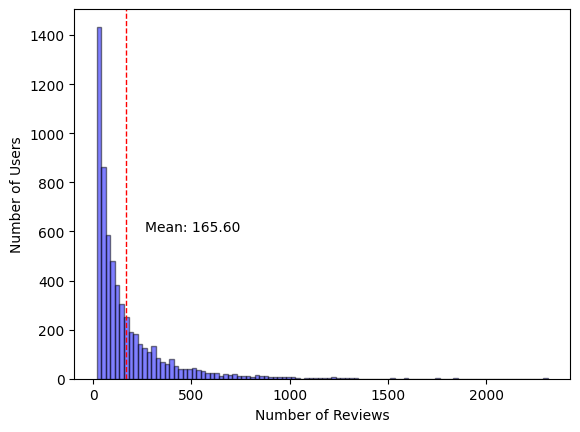

In [13]:
# user_id review count
user_review_count = ml_ratings['user_id'].value_counts()
user_review_count.plot.hist(bins=100, alpha=0.5, color='b', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.axvline(user_review_count.mean(), color='r', linestyle='dashed', linewidth=1)
plt.text(user_review_count.mean() + 100, 600, 'Mean: {:.2f}'.format(user_review_count.mean()))
print('top 90% (number of reviews):', user_review_count.quantile(0.9))

In [14]:
ml_ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


We will not be using timestamp, we will drop it, as it is too complicated for our task. This might be useful for a time-based recommendation system, where we would recommend movies that are more recent, taking into account that the user's taste might have changed over time.\
We will only keep the ratings of users are in the top 10% in number of ratings, to reduce the size of the matrix and to keep recommendations relevant.

In [15]:
ml_ratings.drop(columns=['timestamp'], inplace=True)
# keep users that have a review count in the top 10%
user_review_count = ml_ratings['user_id'].value_counts()
user_review_count = user_review_count[user_review_count >= user_review_count.quantile(0.9)]
ml_ratings = ml_ratings[ml_ratings['user_id'].isin(user_review_count.index)]
ml_ratings

,user_id,movie_id,rating
799,10,2622,5
800,10,648,4
801,10,2628,3
802,10,3358,5
803,10,3359,3
...,...,...,...
999518,6036,562,4
999519,6036,1096,4
999520,6036,1097,4
999521,6036,1099,4


#### Removing useless columns

In [16]:
ml_df.drop(columns=['tconst', 'title', 'startYear'], inplace=True)

#### Summary

In [17]:
ml_df

,movie_id,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,averageRating,numVotes
0,1,1995,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,8.3,1076431
1,2,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,7.1,380163
2,3,1995,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,6.6,29874
3,4,1995,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,6.0,12314
4,5,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,6.1,41946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,3948,2000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,7.0,357427
2998,3949,2000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,8.3,904474
2999,3950,2000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6.9,43504
3000,3951,2000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.2,1734


In [18]:
ml_ratings

,user_id,movie_id,rating
799,10,2622,5
800,10,648,4
801,10,2628,3
802,10,3358,5
803,10,3359,3
...,...,...,...
999518,6036,562,4
999519,6036,1096,4
999520,6036,1097,4
999521,6036,1099,4


In [19]:
user_item_matrix = ml_ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
10,5.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
26,3.0,0.0,2.0,3.0,5.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,4.0,3.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
53,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972,4.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
5996,5.0,3.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,4.0,...,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0
6000,3.0,3.0,3.0,0.0,3.0,0.0,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Development

We will use SVD from surprise library to predict ratings for simplicity and performance (not reimplenting the algorithm from scratch). It doesn't take the features of the movies into account, but it's a good start.

In [130]:
!pip install scikit-surprise

In [20]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [21]:
ratings_df = user_item_matrix.stack().reset_index()
ratings_df.columns = ['user_id', 'movie_id', 'rating']
ratings_df

,user_id,movie_id,rating
0,10,1,5.0
1,10,2,5.0
2,10,3,0.0
3,10,4,0.0
4,10,5,0.0
...,...,...,...
2192515,6036,3948,0.0
2192516,6036,3949,0.0
2192517,6036,3950,0.0
2192518,6036,3951,0.0


In [22]:
reader = Reader(rating_scale=(user_item_matrix.min().min(), user_item_matrix.max().max()))

In [23]:
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)
model = SVD()
model.fit(trainset)

In [24]:
ratings_df[ratings_df['movie_id'] == 3948]

,user_id,movie_id,rating
3619,10,3948,4.0
7243,26,3948,0.0
10867,48,3948,3.0
14491,53,3948,0.0
18115,58,3948,4.0
...,...,...,...
2178019,5972,3948,2.0
2181643,5996,3948,3.0
2185267,6000,3948,0.0
2188891,6016,3948,0.0


In [25]:
user_ids = [10, 26]  # Example user IDs
movie_id = 3948  # Example movie ID
actual_ratings = ratings_df[ratings_df['movie_id'] == movie_id]

for i, user_id in enumerate(user_ids):
    # Predict rating for the specified user and movie
    prediction = model.predict(uid=user_id, iid=movie_id)
    print(f'Predicted rating for user {user_id} for movie {movie_id}: {prediction.est}, actual rating: {actual_ratings[actual_ratings["user_id"] == user_id]["rating"].values[0]}')

Predicted rating for user 10 for movie 3948: 1.2264810425963728, actual rating: 4.0
Predicted rating for user 26 for movie 3948: 0.8322096763076611, actual rating: 0.0


Not that great on this example.

In [26]:
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.0325
MAE:  0.5963


## Recommendation Algorithm

Let's build a user preference matrix using the number and mean rating of each genre for each user. This will be used in the recommendation algorithm to add an additional weight to the recommendations. We'll try to recommend movies with a genra that is 'heavily' reviews and rated great by the user.\
The user preference will contain the average rating per genre weighted by the number of reviews done by the user for that genre.

In [39]:
user_preferences = pd.merge(ml_ratings, ml_df, left_on='movie_id', right_on='movie_id', how='inner')
user_preferences.sort_values(by='user_id', inplace=True)
user_preferences.drop(columns=['movie_id', 'year', 'averageRating', 'numVotes'], inplace=True)
# mean sum of ratings for each user
number_of_reviews_per_genre = user_preferences.drop(columns='rating').groupby('user_id').sum()
number_of_reviews_per_genre

# multiply each column by the rating
sum_rating_per_genre = user_preferences.groupby('user_id').apply(lambda x: x.drop(columns=['rating', 'user_id']).mul(x['rating'], axis=0).sum())

mean_ratings_per_genre = sum_rating_per_genre.div(number_of_reviews_per_genre, axis=0).fillna(0)

# normalize sum_rating_per_genre so the matrix contains the percentage of reviews per genre
sum_rating_per_genre = sum_rating_per_genre.div(sum_rating_per_genre.sum(axis=1), axis=0)

user_preferences = sum_rating_per_genre.mul(mean_ratings_per_genre, axis=0)
user_preferences

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
10,0.356577,0.341808,0.153450,0.306535,0.801251,0.058313,0.010044,0.563448,0.184096,0.015380,0.075330,0.220417,0.032996,0.390007,0.357521,0.141067,0.093280,0.037710
26,0.282305,0.145265,0.043338,0.079160,0.682703,0.046089,0.000000,0.688231,0.022389,0.007449,0.026452,0.045524,0.046412,0.489497,0.124362,0.242124,0.050279,0.017026
48,0.433035,0.252581,0.108930,0.182209,0.462100,0.057665,0.010723,0.409504,0.073868,0.012708,0.041514,0.117239,0.048464,0.227404,0.238384,0.224696,0.153582,0.050040
53,0.381634,0.227537,0.086483,0.154319,0.459008,0.153395,0.004500,0.879075,0.110876,0.034220,0.215992,0.125306,0.114167,0.265354,0.344134,0.431097,0.132834,0.025918
58,0.570866,0.291718,0.106517,0.141469,0.476764,0.109703,0.011548,0.620476,0.084554,0.035643,0.155396,0.070899,0.084848,0.193961,0.473845,0.308607,0.184773,0.027537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972,0.337986,0.221623,0.044229,0.112210,1.100792,0.097686,0.020741,0.644161,0.036082,0.009021,0.112210,0.088712,0.045103,0.293858,0.168798,0.233373,0.117820,0.038706
5996,0.430934,0.249385,0.159088,0.297232,0.610052,0.071224,0.007035,0.453260,0.107284,0.014362,0.144685,0.160080,0.082735,0.353486,0.224437,0.343166,0.089772,0.035253
6000,0.440160,0.286889,0.058900,0.136413,0.479308,0.090807,0.002847,0.582978,0.053464,0.035432,0.040494,0.045713,0.089318,0.206932,0.241167,0.328866,0.114484,0.063798


And for each movie, we will use imdb average rating to add an additional weight and number of votes to add a weight to the recommendation.\
Having a 'lower' average rating and a high number of votes is better than having a 'higher' average rating and a low number of votes.\
The weight is computed as the log of the number of votes times the average rating normalized.

In [156]:
movie_preferences = ml_df.drop(columns=['year']).copy()
movie_preferences.set_index('movie_id', inplace=True)
movie_preferences = movie_preferences[~movie_preferences.index.duplicated(keep='first')]
movie_preferences.numVotes = np.log(movie_preferences.numVotes)
movie_preferences.averageRating = movie_preferences.averageRating / movie_preferences.averageRating.max()
movie_preferences['voting_weight'] = movie_preferences['numVotes'] * movie_preferences['averageRating']
movie_preferences.drop(columns=['numVotes', 'averageRating'], inplace=True)
movie_preferences

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,voting_weight
movie_id,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,12.395703
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,9.808959
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,7.313044
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,6.076447
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.981639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9.624388
3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12.240366
3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.924322


In [160]:
movie_preferences.voting_weight.describe()

count    2987.000000
mean        6.913248
std         2.068403
min         1.329481
25%         5.421642
50%         6.756623
75%         8.335363
max        14.884478
Name: voting_weight, dtype: float64

In [161]:
def couple_score(user_id_1: int, user_id_2:int, movie_id: int) -> float:
    """
    Compute the couple score for two users and a movie
    The couple score penalize the score if one user likes a movie and the other dislikes it.
    
    :param user_id_1: the first user id
    :param user_id_2: the second user id
    :param movie_id: the movie id
    
    :return: the couple score
    """
    user_1_pref = user_preferences.loc[user_id_1].to_numpy()
    user_2_pref = user_preferences.loc[user_id_2].to_numpy()
    movie_pref = movie_preferences.loc[movie_id]
    movie_feat = movie_pref[:-1].to_numpy()
    movie_voting_weight = movie_pref[-1]
    
    user1_score = user_1_pref.dot(movie_feat) * movie_voting_weight 
    user2_score = user_2_pref.dot(movie_feat) * movie_voting_weight
    
    return user1_score * user2_score if user1_score * user2_score > 0 else user1_score + user2_score

In [162]:
user_ids = []
item_ids = []
ratings = []

for (uid, iid, rating) in trainset.all_ratings():
    user_ids.append(trainset.to_raw_uid(uid))
    item_ids.append(trainset.to_raw_iid(iid))
    ratings.append(rating)

# Create a DataFrame
train_df = pd.DataFrame({
    'user_id': user_ids,
    'item_id': item_ids,
    'rating': ratings
})

train_df

,user_id,item_id,rating
0,3391,2343,0.0
1,3391,3689,0.0
2,3391,2569,0.0
3,3391,1189,0.0
4,3391,905,0.0
...,...,...,...
1644385,710,730,0.0
1644386,710,2797,4.0
1644387,710,271,0.0
1644388,710,1035,0.0


In [183]:
def recommender(user_id_1: int, user_id_2: int, n: int) -> list:
    """
    Recommends n movies for user_id_1 based on the ratings of user_id_2.
    The movies has not been watched by either user.
    
    Parameters:
    user_id_1 (int): The user ID to recommend movies to.
    user_id_2 (int): The user ID to base recommendations on.
    n (int): The number of movies to recommend.
    
    Returns:
    list: A list of n movie IDs.
    """
    # predict coupled ratings for all movies
    rating_df = ml_df[['movie_id']].copy()
    
    # remove movies that have been watched by either user, (while evaluating the score we will consider that movies in the test set have not been watched by the user)
    user_1_movies = train_df[train_df['user_id'] == user_id_1]['item_id']
    user_2_movies = train_df[train_df['user_id'] == user_id_2]['item_id']
    watched_movies = pd.concat([user_1_movies, user_2_movies], axis=0)
    rating_df = rating_df[~rating_df['movie_id'].isin(watched_movies)]
    
    rating_df['score'] = rating_df['movie_id'].apply(lambda x: couple_score(user_id_1, user_id_2, x))
    
    rating_df.sort_values(by='score', ascending=False, inplace=True)
    
    # keep only the top n movies
    rating_df = rating_df.head(n)
    
    return rating_df

In [197]:
recommender(10, 26, 10)

,movie_id,score
1498,2001,275.322758
1551,2065,267.195723
1162,1542,193.935112
691,912,190.523867
1179,1566,173.666461
1041,1380,164.142589
92,110,159.373813
1906,2502,147.503194
201,247,140.572562
179,215,138.352983


## Evaluation

We will create test_couple, that are couples of user that have rated at least 10 movies in common.\
We will compute the number of good, neutral and bad recommendations made by the algorithm for each couple.

In [194]:
test_df = pd.DataFrame(testset)
test_df.columns = ['user_id', 'movie_id', 'rating']
# remove all movies that are rated 0 by either user
test_df = test_df[(test_df['rating'] != 0)]
test_df

,user_id,movie_id,rating
1,3067,2312,5.0
6,4167,2411,2.0
27,1676,589,5.0
29,3292,920,4.0
31,4277,2932,4.0
...,...,...,...
548092,3762,2939,4.0
548111,235,1213,5.0
548112,4053,1347,4.0
548113,4482,2409,3.0


In [216]:
from itertools import combinations

def user_couple_dataframe() -> pd.DataFrame:
    """
    Create a DataFrame with all user couples that have rated at least 10 movie in common.
    
    Returns:
    DataFrame: A DataFrame with all user couples that have rated at least one movie in common.
    """
    user_couples = []
    for user1, user2 in combinations(user_review_count.index, 2):
        common_movies = set(user_item_matrix.loc[user1].index) & set(user_item_matrix.loc[user2].index)
        if len(common_movies) >= 10:
            user_couples.append({'user_id_1': user1, 'user_id_2': user2})
    return pd.DataFrame(user_couples)

In [217]:
test_couples = user_couple_dataframe()
test_couples

,user_id_1,user_id_2
0,4169,1680
1,4169,4277
2,4169,1941
3,4169,1181
4,4169,889
...,...,...
182705,4258,4897
182706,4258,26
182707,639,4897
182708,639,26


We will reduce the size of the dataset to 1% to simplify the evaluation process.

In [220]:
test_couples = test_couples.head(1800)
test_couples

,user_id_1,user_id_2
0,4169,1680
1,4169,4277
2,4169,1941
3,4169,1181
4,4169,889
...,...,...
1795,4277,4150
1796,4277,2581
1797,4277,673
1798,4277,199


In [221]:
from tqdm import tqdm

In [227]:
def evaluate_recommendation(n: int) -> float:
    """
    If a recommended movie is rated above 3 by both users, it is considered a good recommendation.
    If one user rates the movie below 3, it is considered a bad recommendation.
    If none of the users have rated the movie, it is considered a neutral recommendation.
    
    Parameters:
    :param n: the number of recommendations to evaluate
    
    Returns:
    list: A list of n movie IDs.
    """
    good_recommendations = []
    bad_recommendations = []
    neutral_recommendations = []
    
    
    
    for index, row in tqdm(test_couples.iterrows(), total=test_couples.shape[0]):
        user_1 = row['user_id_1']
        user_2 = row['user_id_2']
        
        recommended_movies = recommender(user_1, user_2, n)
        
        current_good_recommendations = 0
        current_bad_recommendations = 0
        current_neutral_recommendations = 0
        
        for index, row in recommended_movies.iterrows():
            movie_id = row['movie_id']
            try:
                user_1_rating = test_df[(test_df['user_id'] == user_1) & (test_df['movie_id'] == movie_id)]['rating'].values[0]
                user_2_rating = test_df[(test_df['user_id'] == user_2) & (test_df['movie_id'] == movie_id)]['rating'].values[0]
            except:
                current_neutral_recommendations += 1
                continue
            
            if user_1_rating > 3 and user_2_rating > 3:
                current_good_recommendations += 1
            else:
                current_bad_recommendations += 1
                
        good_recommendations.append(current_good_recommendations)
        bad_recommendations.append(current_bad_recommendations)
        neutral_recommendations.append(current_neutral_recommendations)
        
    return good_recommendations, bad_recommendations, neutral_recommendations

In [229]:
good_recommendations_1, bad_recommendations_1, neutral_recommendations_1 = evaluate_recommendation(1)
good_recommendations_3, bad_recommendations_3, neutral_recommendations_3 = evaluate_recommendation(3)
good_recommendations_5, bad_recommendations_5, neutral_recommendations_5 = evaluate_recommendation(5)

100%|██████████| 1800/1800 [01:31<00:00, 19.67it/s]


In [242]:
top1_df = pd.DataFrame({"top1_good": good_recommendations_1, "top1_neutral": neutral_recommendations_1, "top1_bad": bad_recommendations_1})
top3_df = pd.DataFrame({"top3_good": good_recommendations_3, "top3_neutral": neutral_recommendations_3, "top3_bad": bad_recommendations_3})
top5_df = pd.DataFrame({"top5_good": good_recommendations_5, "top5_neutral": neutral_recommendations_5, "top5_bad": bad_recommendations_5})

What we want to see is a high number of good recommendations and a low number of bad recommendations.\
Having a high number of neutral recommendations is not a bad thing, it means that the algorithm is NOT making bad recommendations.\
(The sum of good, neutral and bad recommendations should be equal to the number of recommendations made)

In [248]:
top1_df.describe()

,top1_good,top1_neutral,top1_bad
count,1800.000000,1800.000000,1800.000000
mean,0.441667,0.308333,0.250000
std,0.496724,0.461933,0.433133
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.250000
max,1.000000,1.000000,1.000000


Top 1 means, taking the top 1 recommendation, we got a mean good recommendation of 0.44 (44% of the time the recommendation was good).\
But having bad recommendation mean of 0.22 (22% of the time the recommendation was bad) is that good.

In [249]:
top3_df.describe()

,top3_good,top3_neutral,top3_bad
count,1800.000000,1800.000000,1800.000000
mean,1.048333,1.267222,0.684444
std,0.863951,0.882939,0.764980
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,1.000000
max,3.000000,3.000000,3.000000


Taking into account the results of top 1 evaluation. The top 3 evaluation has better results, having a second and third gives promising recommendations.\
But the mean of bad recommendations increase aswell, meaning that the algorithm is not perfect.

In [247]:
top5_df.describe()

,top5_good,top5_neutral,top5_bad
count,1800.000000,1800.000000,1800.000000
mean,1.506111,2.385000,1.108889
std,1.104826,1.210982,1.015899
min,0.000000,0.000000,0.000000
25%,1.000000,1.750000,0.000000
50%,1.000000,2.000000,1.000000
75%,2.000000,3.000000,2.000000
max,5.000000,5.000000,5.000000


Top 5 keeps the same trend.

## Conclusion

The resulting recommendation algorithm is not perfect, but it is a good start.\
The couple scoring system for recommendations is not perfect, and could greatly be improved by not taking arbitrary formulas for the weights of the recommendations.\
Maybe implementing a neural network to learn the weights of the recommendations would be a good idea.